# Chapter 5 - Resampling Methods: Applied Exercises

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

In [3]:
def error_rate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    correctly_classified = cm[0][0] + cm[1][1]
    total = np.sum(cm)
    percentage = correctly_classified/total*100
    error_rate = round(100 - percentage, 4)

    print('Error rate in percent:\t' + str(error_rate) +'%')

### Exercise 5

In [4]:
default = pd.read_csv('data/Default.csv')
default.head() # remove unnamed column

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


In [5]:
default.default.replace(('No', 'Yes'), (0,1), inplace=True)
default.student.replace(('No', 'Yes'), (0,1), inplace=True)
default = default.iloc[:, 1:]
default.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [6]:
# Number of categroies
default['default'].nunique()

# Count yes and no for default
default.groupby('default').count()

# more compact counts
default.default.value_counts()

0    9667
1     333
Name: default, dtype: int64

In [7]:
# a) fit logReg -> default ~ income + balance
default_X = default[['income', 'balance']]
default_y = default['default']

logReg_full = LogisticRegression(penalty='none').fit(default_X, default_y)

default_y_predict = logReg_full.predict(default_X)
error_rate(default_y, default_y_predict)

[[9629   38]
 [ 225  108]]
Error rate in percent:	2.63%


In [8]:
# b) estimate test error
# i) train / test split
X_train, X_test, y_train, y_test =  train_test_split(default_X, default_y, test_size=0.5, random_state=42)

# ii) Fit multiple logReg
logReg_val = LogisticRegression(penalty='none').fit(X_train, y_train)

# iii) obtain a prediction of default status for each individual in the validation set
y_predict_val = logReg_val.predict(X_test)

# iv) compute the validation set error
error_rate(y_test, y_predict_val)

[[4839    2]
 [ 159    0]]
Error rate in percent:	3.22%


In [9]:
# c) repeat b) three times using three different splits
test_sizes = [0.33, 0.4, 0.6]

for test_size in test_sizes:
    X_train, X_test, y_train, y_test =  train_test_split(default_X, default_y, test_size=test_size, random_state=420)
    logReg_val = LogisticRegression(penalty='none').fit(X_train, y_train)
    y_predict_val = logReg_val.predict(X_test)
    print(f'Test size: {test_size}')
    error_rate(y_test, y_predict_val)

Test size: 0.33
[[3179   13]
 [  78   30]]
Error rate in percent:	2.7576%
Test size: 0.4
[[3870    2]
 [ 128    0]]
Error rate in percent:	3.25%
Test size: 0.6
[[5803    1]
 [ 196    0]]
Error rate in percent:	3.2833%


In [10]:
# d) fit logReg -> default ~ income + balance + student(0/1) and estimate test error
default_X = default[['income', 'balance', 'student']]

test_sizes = [0.33, 0.4, 0.5, 0.6]

for test_size in test_sizes:
    X_train, X_test, y_train, y_test =  train_test_split(default_X, default_y, test_size=test_size, random_state=420)
    logReg_val = LogisticRegression(penalty='none').fit(X_train, y_train)
    y_predict_val = logReg_val.predict(X_test)
    print(f'Test size: {test_size}')
    error_rate(y_test, y_predict_val)

Test size: 0.33
[[3165   27]
 [  83   25]]
Error rate in percent:	3.3333%
Test size: 0.4
[[3870    2]
 [ 128    0]]
Error rate in percent:	3.25%
Test size: 0.5
[[4796   40]
 [ 125   39]]
Error rate in percent:	3.3%
Test size: 0.6
[[5766   38]
 [ 153   43]]
Error rate in percent:	3.1833%


### Exercise 6

In [11]:
# a) determine estimated SE for coefficients (logReg -> default ~ income + balance)
import statsmodels.api as sm

default_X = default[['income', 'balance']]
X2 = sm.add_constant(default_X)

logReg2 = sm.Logit(default_y, X2).fit()
print(logReg2.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                  0.4594
Time:                        11:26:39   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99

In [12]:
# b) write boot.fn() function that outputs the coefficient estimates for income and balance
def boot_fn(X, y, index_lower, index_upper):
    X = sm.add_constant(X).iloc[index_lower:index_upper, :]
    y = y.iloc[index_lower:index_upper]
    model = sm.Logit(y, X).fit()

    return model.params

coef = boot_fn(default_X, default_y, 0, 500)
print(coef)


Optimization terminated successfully.
         Current function value: 0.079979
         Iterations 10
const     -11.678916
income      0.000025
balance     0.005774
dtype: float64


In [13]:
# c) use bootstrap to estimate the SEs of the logReg coefficients 
from sklearn.utils import resample


def bootstrap_sample(data):
    boots_dataset = resample(data, replace=True, n_samples=len(data))
    return boots_dataset


def boot_fn(X, y):
    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit(disp=0)

    return model.params


def boots_se(alpha):
    alpha_mean = np.mean(alpha)
    alpha_tilde = 0

    for a in alpha:
        alpha_tilde += (a - alpha_mean)**2

    return np.sqrt(1/(len(alpha)-1) * alpha_tilde)


const = []
income = []
balance = []


for b in range(0,100):
    boots_set = bootstrap_sample(default)
    coef = boot_fn(boots_set[['income', 'balance']], boots_set['default'])

    const.append(coef[0])
    income.append(coef[1])
    balance.append(coef[2])

print('Mean values of const, income, balance')
print(np.mean(const), np.mean(income), np.mean(balance))
print()
print('Std errors of const, income, balance')
print(boots_se(const), boots_se(income), boots_se(balance))

Mean values of const, income, balance
-11.563301492707392 2.0872014689267048e-05 0.005660941972932972

Std errors of const, income, balance
0.4194997328915936 5.078257113970408e-06 0.00022485043599329384


In [14]:
# d) comment on the estimated standard errors obtained

Passt scho - stimmen überein.

### Exercise 7

In [15]:
weekly = pd.read_csv('data/Weekly.csv')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [16]:
weekly.Direction.replace(('Down', 'Up'), (0,1), inplace=True)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1


In [17]:
# a) fit logReg -> Direction ~ Lag1 + Lag2
weekly_X = weekly[['Lag1', 'Lag2']]
weekly_y = weekly['Direction']

logReg_full = LogisticRegression(penalty='none').fit(weekly_X, weekly_y)

weekly_y_predict = logReg_full.predict(weekly_X)
error_rate(weekly_y, weekly_y_predict)

[[ 38 446]
 [ 38 567]]
Error rate in percent:	44.4444%


In [18]:
# b) fit logReg -> Direction ~ Lag1 + Lag2 with all but the first observation 
weekly_loo_X = weekly_X.iloc[1:, :]
weekly_loo_y = weekly_y[1:]

weekly_single_X = weekly_X.iloc[:1, :]
weekly_single_y = weekly_y[:1]


logReg_loo = LogisticRegression(penalty='none').fit(weekly_loo_X, weekly_loo_y)

weekly_y_predict = logReg_full.predict(weekly_single_X)


In [19]:
# c) use the model from b= to predict the direction of the first observation; was it classified correctly?
error_rate(weekly_single_y, weekly_y_predict)

print(weekly_single_y) 
print(weekly_y_predict)

[[0 1]
 [0 0]]
Error rate in percent:	100.0%
0    0
Name: Direction, dtype: int64
[1]


In [20]:
# d) for loop i-n:
# i) fit a logReg 
# ii) compute the posterior probability of the market moving up for the ith observation
# iii) use the posterior probability for the ith observation in order to predict whether or not the market moves up
# iv) Determine whether or not an error was made in predicting the direction for the ith observation (1 = error, 0 = none)

errors = []
y_pred = []
y_test = []

for i in range(0, len(weekly)):
    # Leave one out observataion.
    weekly_single_X = weekly_X.iloc[i:i+1, :]
    weekly_single_y = weekly_y.iloc[i:i+1]

    # Rest of the data set.
    weekly_loo_X = weekly_X.drop(index=weekly_X.index[i], axis=0, inplace=False)
    weekly_loo_y = weekly_y.drop(index=weekly_y.index[i], axis=0, inplace=False)

    logReg_loo = LogisticRegression(penalty='none').fit(weekly_loo_X, weekly_loo_y)
    weekly_y_predict = logReg_full.predict(weekly_single_X)

    y_pred.append(weekly_y_predict)
    y_test.append(weekly_single_y)

    # Calculate confusion matrix.
    cm = confusion_matrix(weekly_single_y, weekly_y_predict, labels=[0, 1])
    errors.append(cm[0][0] + cm[1][1])


In [21]:
# e) take the avg of the n numbers obtained in d) in order to obtain the LOOCV estimate for the test error
print(f'Mean error: {1 - np.mean(errors)}')

error_rate(y_test, y_pred)

Mean error: 0.4444444444444444
[[ 38 446]
 [ 38 567]]
Error rate in percent:	44.4444%


### Exercise 8

In [22]:
# a) generate simulated data
np.random.RandomState(42)
norm_X = np.random.normal(size=100)
norm_y = norm_X - 2 * norm_X**2 + np.random.normal(size=100)

Model: $y = \beta_0 + x_1 \beta_1$

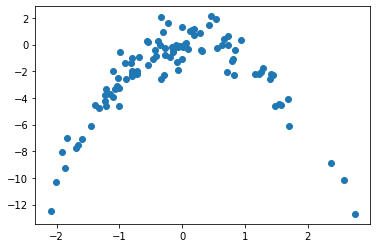

In [23]:
# b) scatterplot of X against Y
plt.scatter(norm_X, norm_y)

In [24]:
# c) set a random seed and compute the LOOCV errors
# i), ii), iii), iv)

generated_data = pd.DataFrame({'y' : norm_y,
                            'x_1' : norm_X,
                            'x_2' : norm_X**2,
                            'x_3' : norm_X**3,
                            'x_4' : norm_X**4})
                            

In [25]:
generated_data.head()

,y,x_1,x_2,x_3,x_4
0,-0.027713,-0.347490,0.120749,-0.041959,0.014580
1,-1.872236,-0.071206,0.005070,-0.000361,0.000026
2,-3.268019,-1.000555,1.001111,-1.001667,1.002223
3,0.754677,0.191561,0.036696,0.007029,0.001347
4,0.675127,0.735843,0.541465,0.398433,0.293184


In [26]:
error = []

for j in range(1, 5):

    mse = []

    for i in range(0, len(generated_data)):
        # Leave one out observataion.
        generated_data_single_X = generated_data.iloc[i:i+1, 1:j+1]
        generated_data_single_y = generated_data.iloc[i:i+1, :1]

        # Rest of the data set.
        generated_data_loo = generated_data.drop(index=generated_data.index[i], axis=0, inplace=False)
        generated_data_loo_X = generated_data_loo.iloc[:, 1:j+1]
        generated_data_loo_y = generated_data_loo.iloc[:, :1]

        lin_model = LinearRegression().fit(generated_data_loo_X, generated_data_loo_y)
        y_pred = lin_model.predict(generated_data_single_X)

        mse.append((y_pred - generated_data_single_y)**2)

    error.append(np.mean(mse))
    print(f'Model {j}, MSE = {np.mean(mse)}')

    

Model 1, MSE = 10.252297293904777
Model 2, MSE = 0.978879862574932
Model 3, MSE = 0.9719545256747153
Model 4, MSE = 0.9995090012760306


In [27]:
# d) repeat c) using a different seed

# makes no sense

In [28]:
# e) which of the models in c) had the smallest LOOCV error?

# Model 2 has tht samllest error.

In [29]:
# f) comment on the statistical significance of the coefficients in c)


### Exercise 9

In [30]:
boston = pd.read_csv('data/Boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [39]:
# a) estimate population mean of medv
boston_mean = boston['medv'].mean()
print(boston_mean)

22.532806324110698


In [43]:
# b) provide an estimate of the standard error of a)
print(boots_se(boston['medv']) / np.sqrt(len(boston)))
print(boston['medv'].std() / np.sqrt(len(boston)))

0.4088611474975351
0.4088611474975351


In [47]:
# c) estimate SE of a) using bootstrap
coefs = []

for b in range(0,1000):
    boots_set = bootstrap_sample(boston)
    coef = boots_set['medv'].std() / np.sqrt(len(boots_set))
    coefs.append(coef)

print(f'Mean: {np.mean(coefs)}')
print(f'Std. error: {boots_se(coefs)}')

Mean: 0.40794012858164613
Std. error: 0.0166617429629636


In [53]:
# d) provide a 95% CI based on c) and compare it to t-Test
from scipy.stats import t, ttest_ind

print(t(df=len(boston) - 1).ppf((0.025, 0.975)))

# CI for mean
print(boston_mean - 2 * np.mean(coefs), boston_mean + 2 * np.mean(coefs))

# T-Test
#ttest_ind()
t_value = (boston_mean - 0) / np.mean(coefs)

if t_value > t(df=len(boston) - 1).ppf((0.025, 0.975))[1]:
    print("Signifikant")
else :
    print('Nicht signifikant')

[-1.96467264  1.96467264]
21.716926066947405 23.34868658127399
Signifikant


In [54]:
# e) provide an estimate for the median of medv
boston_median = boston['medv'].median()
print(boston_median)

21.2


In [55]:
# f) estimate SE of median e) using bootstrap
coefs = []

for b in range(0,1000):
    boots_set = bootstrap_sample(boston)
    coef = boots_set['medv'].median() 
    coefs.append(coef)

print(f'Mean: {np.mean(coefs)}')
print(f'Std. error: {boots_se(coefs)}')

Mean: 21.1755
Std. error: 0.37718300202556393


In [56]:
# g) provide an estimate for tenth percentile of medv
print(np.percentile(boston['medv'], 10))

12.75


In [57]:
# h) use bootstrap to estimate SE of g)
coefs = []

for b in range(0,1000):
    boots_set = bootstrap_sample(boston)
    coef = np.percentile(boots_set['medv'], 10)
    coefs.append(coef)

print(f'Mean: {np.mean(coefs)}')
print(f'Std. error: {boots_se(coefs)}')

Mean: 12.747950000000001
Std. error: 0.49136517707020966
